# A script for analysing past interannual variability

Dataset used: 

_Ilyas, M., Brierley, C.M. and Guillas, S., 2017. Uncertainty in regional temperatures inferred from sparse global observations: Application to a probabilistic classification of El Niño. Geophysical Research Letters, 44(17), pp.9068-9074._

Code written by Jarmo Kikstra, last version 11/12/2019

For uncertainties analysis and more code for intermediary plotting, see other files (e.g. jkikstra/climvar/IlyasPastVariability.ipynb)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#from netCDF4 import Dataset # remove in final version if not actually used.
import pandas as pd
import xarray as xr
import math
from scipy import stats
import pylab
import seaborn as sns


startyr = 1850
endyr = 2018
climateperiod = 30
halfclimperiod = np.floor(climateperiod)
numyears_data = endyr - startyr + 1

#scipy.signal.detrend

## PAGE-ICE masking functions

### The regions as defined in PAGE-ICE

In [7]:
# Mapping is conform data provided for PAGE-ICE documentation.
regions = {
    1 : 'eu',
    2 : 'rus+',
    3 : 'usa',
    4 : 'chi+',
    5 : 'ind+',
    6 : 'afr',
    7 : 'lat',
    8 : 'oth'    
}
# some parameters to increase readability of the code:
numregions = len(regions)

### Setting up directory and selecting maskig file

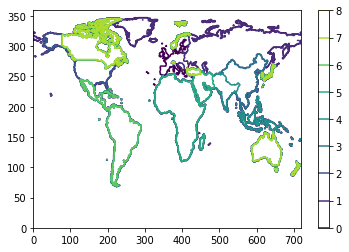

In [9]:
# DOCUMENTATION:
# naming convention:
## grid = Ilyas 36x72 grid
## mask / fullmask = 180 x 360 

# load pagemask.nc file using xarray
dsdir = 'data/'
dsname = 'pagemask.nc'
DS = xr.open_dataset(dsdir + dsname)
da = DS.world # select variable
mask = da.values # turn dataset into numpy array
    # NB.... mask.shape != grid.shape....

#np.place(mask, mask<1, np.nan)
plt.contour(mask)
plt.colorbar()

### Take original masking set and translate it to 8 separate masking sets (still the original high resolution) 

In [10]:
# global variables used:
# - regions

# make 8 separate 1-0 masks, full resolution
def create_separate_masks(fullmask):
    maskingset = np.zeros((len(regions),fullmask.shape[0],fullmask.shape[1]))
    for k in range (1,len(regions)+1):
        for ii in range(fullmask.shape[0]):
            for jj in range(fullmask.shape[1]):
                if fullmask[ii][jj] == k:
                    
                    maskingset[k-1][ii][jj] = 1

    return maskingset

maskingset = create_separate_masks(mask)

### Function for applying PAGE-masks to a dataset, returning dataset as 3d matrix with (coarse) coastally weighted data per gridpoint, with a dimension for every region.

In [11]:
# global variables used:
# - regions, 
# - mask, 
# - maskingset


# now, for eventual calculations, we don't create a 1/0 masking set, but rather just a weighted grid!! 

def create_weighted_grids(grid): # grid should be input of 36 x 72 (so for 1 time entry!!)
    weighted_grid = np.zeros((len(regions), grid.shape[0],grid.shape[1]))
    iratio = int(mask.shape[0]/grid.shape[0]) # = 10
    jratio = int(mask.shape[1]/grid.shape[1]) # = 10
    
    # on the t_anom grid.
    for k in range(len(regions)):
        for i in range(grid.shape[0]): # latitude
            for j in range(grid.shape[1]): # longitude
                weighted_grid[k][i][j] = np.mean(maskingset[k, i*iratio:(i*iratio+iratio), j*jratio:(j*jratio+jratio)]) # ratios of scaling
#                 if weighted_grid[k][i][j] == 0.:
#                     weighted_grid[k][i][j] = np.nan
    return weighted_grid        


## Reading and manipulating data for analysis

### For Median Only

#### Loading data

In [12]:
# load the medians of the temperature anomalies from the datafile
dsname = 'ensemble_statistics.ann_wrt_18501900.nc' 
DS = xr.open_dataset(dsdir + dsname, decode_times=False)
t_anom_ds = DS['median']     # yearly data; [167 x 36 x 72], float32
t_anom = t_anom_ds.values

# Performing analysis

### Create regional mean data, now including area weighting

In [14]:
# area weighting for when creating means, etc.
alat = np.linspace(-87.5, 87.5, 36)
def areaweight(lat):
    degree = abs(alat[lat])
    weight = np.cos(degree*np.pi/180)
    
    return weight

In [15]:
# global variables used:
# - regions
# - weighted_grid
# - numregions
# - numyears_data
# - ...

# data = t_anom

def do_regional_data(data):
    # to check the size of the input 'data' and adjust the parameters accordingly
    if data.ndim == 3:
        numyears = data.shape[0]
        grid_lat = data.shape[1]
        grid_lon = data.shape[2]
    if data.ndim == 2:
        numyears = 1
        grid_lat = data.shape[0]
        grid_lon = data.shape[1]
    
    # create variable to store processed data:
    regional_data = np.zeros((numregions, numyears)) # for storing weighted mean temperature (per year and per region)
                              
    # apply masking weights:                           
    # N.B. below highly nested loop is very slow. Is there a quicker way using Linear Algebra?
    for c in range(numregions): # run over all regions
        for year in range(numyears): # run over all years
            t_sum = 0
            areaweights_sum = 0
            for i in range(grid_lat): 
                for j in range(grid_lon):
                    # this highly nested loop applies the weights of the masked grid to the data.
                        ## apply area weighting here
                    
                    if data.ndim == 2:
                        t_sum = t_sum + data[i][j] * weighted_grid[c][i][j]*areaweight(i)
                        areaweights_sum = areaweights_sum + weighted_grid[c][i][j]*areaweight(i)
                    else:
                        t_sum = t_sum + data[year][i][j] * weighted_grid[c][i][j]*areaweight(i)
                        areaweights_sum = areaweights_sum + weighted_grid[c][i][j]*areaweight(i)
            t_mean = t_sum/areaweights_sum
            regional_data[c][year] = t_mean     
    
    return regional_data
    
regional_data = do_regional_data(t_anom)

### Detrend regional and global mean data.
Done by creating a 30yr array for each year, and subtracting the trend from that climatic period. 

In [17]:
# global variables used:
# - t_anom
# - numregions
# - numyears_data
# - climateperiod
    
                    # perhaps add argument and adaptable code to specify the form of detrending
def detrend_data_and_climatic_data(regional_data):    
    
    # create variable to store processed data:
    regional_data_detrended = np.zeros((numregions, numyears_data, climateperiod)) # for storing detrended annual weighted mean temperature (with full climatic period data) (per year and per region)
    regional_data_notdetrended = np.zeros((numregions, numyears_data, climateperiod)) # for find_uncertainty()
    regional_clim_data = np.zeros((numregions, numyears_data)) # for storing non-detrended climatic data
    regional_clim_data_detrended = np.zeros((numregions, numyears_data)) # for find_uncertainty()
    
    # regional detrending
## check ceil and floor....
    for c in range(numregions):
        for k in range(numyears_data):          
            # if in first 30yr of period, climatic regional data will be filled with nan.
            if k < math.floor(climateperiod): 
                regional_data_detrended[c][k] = np.nan
                regional_clim_data[c][k] = np.nan
            else:
                # take linear trend for every 30yr climatic period 
                # do (linear=1) fitting on the selected data [x,y,orderpolynomial]:
                
                # selecting year + 29 preceding years (as 1986-2015)
                selecteddatawindow = np.squeeze(regional_data[c, k-climateperiod:(k)])
                fit = np.polyfit(list(range(climateperiod)), selecteddatawindow, 1)    
                f = np.poly1d(fit)
                
                regional_data_detrended[c][k][:] = selecteddatawindow - f(list(range(climateperiod)))
                regional_data_notdetrended[c][k][:] = selecteddatawindow
                
                # save climatic data
                regional_clim_data[c][k] = np.mean(selecteddatawindow)
                regional_clim_data_detrended[c][k] = np.mean(selecteddatawindow - f(list(range(climateperiod))))             
    
    
    # global detrending 
    # create variable to store processed data:
    global_data_detrended = np.zeros((numyears_data, climateperiod))
    global_clim_data = np.zeros(numyears_data)
        
    # create the mean temperature for the globe (GMT) for every year.
    t_anom_mean = np.zeros(numyears_data)
    for k in range(numyears_data):
        t_anom_mean[k] = np.mean(t_anom[k])
    
    
    for k in range(numyears_data):
        # if in first 30yr of period, climatic regional data will be filled with nan.
        if k < climateperiod:
            global_data_detrended[k] = np.nan
            global_clim_data[k] = np.nan
        else: 
            # take linear trend for every 30yr climatic period 
            selecteddatawindow = np.squeeze(t_anom_mean[(k-climateperiod):(k)])
            fit = np.polyfit(list(range(climateperiod)), selecteddatawindow, 1)    
            f = np.poly1d(fit)
            
            # subtract fit from global_data and put that into global_data_detrended
            global_data_detrended[k][:] = selecteddatawindow - f(list(range(climateperiod)))
            
            # save climatic data
            global_clim_data[k] = np.mean(selecteddatawindow)  
    
    return regional_data_detrended, global_data_detrended, regional_clim_data, global_clim_data, regional_data_notdetrended, regional_clim_data_detrended
                 
    
regional_data_detrended, global_data_detrended, regional_clim_data, global_clim_data, regional_data_notdetrended, regional_clim_data_detrended = detrend_data_and_climatic_data(regional_data)

### Calculate standard deviations


############################################
Standard deviation of 1986-2015:
############################################
mean SD of eu 0.414868179939074
mean SD of rus+ 0.4396069833902292
mean SD of usa 0.3643523427758104
mean SD of chi+ 0.265187666211356
mean SD of ind+ 0.20128035406592626
mean SD of afr 0.19642782389206548
mean SD of lat 0.15385597594503517
mean SD of oth 0.3622744910097407
global mean SD 0.1100869843768846
############################################


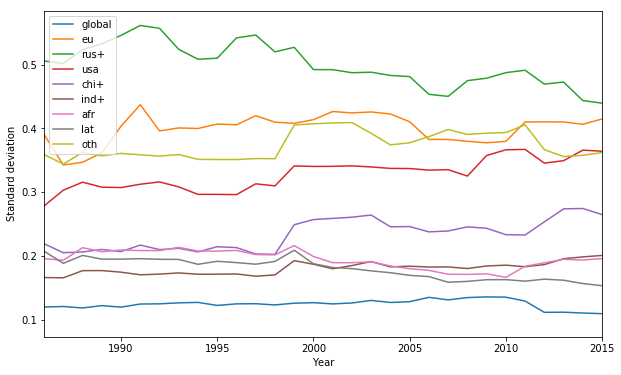

In [56]:
# global variables used:
# - startyr
# - endyr
# - regions
# - numregions
# - numyears_data

def calculate_std(regional_data_detrended, global_data_detrended):
    regional_std = np.zeros((numregions, numyears_data))
    global_std = np.zeros(numyears_data)
    for k in range(numyears_data):
        global_std[k] = np.std(global_data_detrended[k])
        for c in range(numregions):
            regional_std[c][k] = np.std(regional_data_detrended[c][k][:])
    return regional_std, global_std

regional_std, global_std = calculate_std(regional_data_detrended, global_data_detrended)

# plot standard deviations over time:
fig = plt.figure(figsize=(10, 6))
plt.plot(range(startyr,endyr+1), global_std, label = 'global')
for c in range(numregions):
    plt.plot(range(startyr,endyr+1), regional_std[c], label = regions[c+1])
plt.xlim(1986, 2015)
# plt.title('Standard Deviations of Interannual mean temperature (detrended for 31-yr periods)')
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Standard deviation')

print('############################################')
print('Standard deviation of 1986-2015:')
print('############################################')
    # print out mean SDs
for c in range(numregions):
    print('mean SD of ' + str(regions[c+1]) + ' ' + str(regional_std[c, -4]))
print('global mean SD' + ' ' + str(global_std[-4]))

print('############################################')

In [65]:
stats.pearsonr([.1,.11,.1]*15,[.2,.2,.21]*15)

(-0.5, 0.0004700759935950779)

### Calculate correlations between regional and global variability

In [48]:
def calculate_correlations(regional_std, global_std, regional_clim_data, global_clim_data):
    
    
    spearman_correlations_regional_rmt = np.zeros((len(regions),2))
    pearson_correlations_regional_rmt = np.zeros((len(regions),2))
    anova_ftest_regional_rmt = np.zeros((len(regions),2))
    for c in range(numregions):
        # temporarily get rid of nan entries:
        A = regional_std[c][~np.isnan(regional_std[c])]
        B = regional_clim_data[c][~np.isnan(regional_clim_data[c])]
        # use different statistical techniques (these should probably be made more robust):
        spearman_correlations_regional_rmt[c] = stats.spearmanr(A,B) # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        pearson_correlations_regional_rmt[c] = stats.pearsonr(A,B) # stats.pearsonr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        anova_ftest_regional_rmt[c] = stats.f_oneway(A,B) # stats.f_oneway(A,B) -- takes: two arrays -- returns: f-value, p-value || The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid. 1) The samples are independent. 2) Each sample is from a normally distributed population. 3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
    
    spearman_correlations_regional_gmt = np.zeros((len(regions),2))
    pearson_correlations_regional_gmt = np.zeros((len(regions),2))
    anova_ftest_regional_gmt = np.zeros((len(regions),2))
    for c in range(numregions):
        # temporarily get rid of nan entries:
        A = regional_std[c][~np.isnan(regional_std[c])]
        B = global_clim_data[~np.isnan(global_clim_data)]
        # use different statistical techniques (these should probably be made more robust):
        spearman_correlations_regional_gmt[c] = stats.spearmanr(A,B) # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        pearson_correlations_regional_gmt[c] = stats.pearsonr(A,B) # stats.pearsonr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        anova_ftest_regional_gmt[c] = stats.f_oneway(A,B) # stats.f_oneway(A,B) -- takes: two arrays -- returns: f-value, p-value || The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid. 1) The samples are independent. 2) Each sample is from a normally distributed population. 3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
    
#     print(spearman_correlations_regional_rmt)
#     print(pearson_correlations_regional_rmt)
#     print(anova_ftest_regional_rmt)
#     print(spearman_correlations_regional_gmt)
#     print(pearson_correlations_regional_gmt)
#     print(anova_ftest_regional_gmt)
        
calculate_correlations(regional_std, global_std, regional_clim_data, global_clim_data)



### Calculate cross-correlation between regional standard deviations

In [59]:
def calculate_crosscorrelation_sd(regional_std):
    crosscorrelations_sd = np.zeros((numregions, numregions, 2)) # third dimension for: correlation, p-value 
    for c1 in range(numregions):
        for c2 in range(numregions):
            A = regional_std[c1][~np.isnan(regional_std[c1])]
            B = regional_std[c2][~np.isnan(regional_std[c2])]
            crosscorrelations_sd[c1,c2] = stats.pearsonr(A,B)
            crosscorrelations_sd[c2,c1] = stats.pearsonr(B,A)
    return crosscorrelations_sd

crosscorrelations_sd = calculate_crosscorrelation_sd(regional_std)

print('############################################')
print('Writing out cross-correlations (with p-values) for 1986-2015 SDs.')
print('############################################')

df = pd.DataFrame(crosscorrelations_sd[:,:,0])
df.to_csv("output/sd_correlationMatrix.csv")
df = pd.DataFrame(crosscorrelations_sd[:,:,1])
df.to_csv("output/sd_PvalueMatrix.csv")

############################################
Writing out cross-correlations (with p-values) for 1986-2015 SDs.
############################################


### Calculate cross-correlation between regional temperatures

In [60]:
def calculate_crosscorrelation_temp(regional_temp):
    crosscorrelations_temp = np.zeros((numregions, numregions, 2)) # third dimension for: correlation, p-value 
    for c1 in range(numregions):
        for c2 in range(numregions):
            A = regional_temp[c1][~np.isnan(regional_temp[c1])]
            B = regional_temp[c2][~np.isnan(regional_temp[c2])]
            crosscorrelations_temp[c1,c2] = stats.pearsonr(A,B)
            crosscorrelations_temp[c2,c1] = stats.pearsonr(B,A)
    return crosscorrelations_temp

crosscorrelations_temp = calculate_crosscorrelation_temp(regional_data_detrended)

print('############################################')
print('Writing out cross-correlations (with p-values) for 1986-2015 temperatures.')
print('############################################')

df = pd.DataFrame(crosscorrelations_sd[:,:,0])
df.to_csv("output/temp_correlationMatrix.csv")
df = pd.DataFrame(crosscorrelations_sd[:,:,1])
df.to_csv("output/temp_PvalueMatrix.csv")

############################################
Writing out cross-correlations (with p-values) for 1986-2015 temperatures.
############################################
